In [75]:
import pandas as pd

# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/G_1_10_Isnull_diff.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 141 entries, StudyID to 3D_G_Diff_pre3
dtypes: bool(1), float64(97), int64(23), object(20)
memory usage: 76.7+ MB


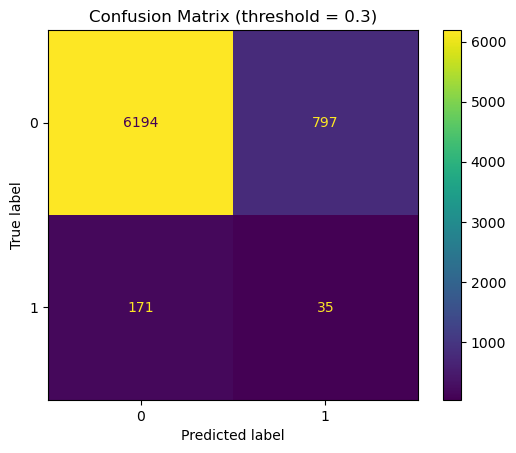

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9731    0.8860    0.9275      6991
           1     0.0421    0.1699    0.0674       206

    accuracy                         0.8655      7197
   macro avg     0.5076    0.5279    0.4975      7197
weighted avg     0.9465    0.8655    0.9029      7197

📈 Evaluation Metrics:
Accuracy:  0.8655
Precision: 0.0421
Recall:    0.1699
F1 Score:  0.0674
ROC AUC:   0.6252
PR AUC:    0.0427

🔍 Feature Importance (Top 15):
               Feature  Importance
18     hungry_weighted    0.050628
20   mean_intensity_1h    0.047841
3         15m_G_Diff_2    0.047349
17            Time_24h    0.041950
34          Sleep_Diff    0.038658
19          EMA_T_Diff    0.036083
2         15m_G_Diff_1    0.035895
22   mean_intensity_3h    0.031630
21   mean_intensity_2h    0.030002
4         15m_G_Diff_3    0.028538
5         15m_G_Diff_4    0.027595
32           TimeInBed    0.026717
6         15m_G_Diff_5    0.02

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/G_1_10_Isnull_diff.csv'
# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

X_columns = [
    "1D_G_Diff", "3D_G_Diff",
    "15m_G_Diff_1", "15m_G_Diff_2", "15m_G_Diff_3", "15m_G_Diff_4", "15m_G_Diff_5",
    "Glucose", "Slope_Pre_1h", "Slope_Pre_2h", "Slope_Pre_2.5h",
    "Mean_Glucose_Pre_1h", "Mean_Glucose_Pre_2h", "Mean_Glucose_Pre_2.5h",
    "Std_Glucose_Pre_1h", "Std_Glucose_Pre_2h", "Std_Glucose_Pre_2.5h",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull",
    "1D_G_Diff_pre1", "1D_G_Diff_pre2", "1D_G_Diff_pre3",
    "3D_G_Diff_pre1", "3D_G_Diff_pre2", "3D_G_Diff_pre3"
]

# Remove rows with missing values
df_model = df[X_columns + ["Onset_GE", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["Onset_GE"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

# Predict
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


In [79]:
# Count label occurrences in train set
print("📊 y_train class distribution:")
print(y_train.value_counts())

# Count label occurrences in test set
print("\n📊 y_test class distribution:")
print(y_test.value_counts())


📊 y_train class distribution:
Onset_GE
0    27962
1    27962
Name: count, dtype: int64

📊 y_test class distribution:
Onset_GE
0    6991
1     206
Name: count, dtype: int64


# RandomizedSearchCV

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    "n_estimators": randint(50, 200),
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": ["balanced"]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=20, scoring='recall', cv=3, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Best parameter combination
print("🔍 Best Hyperparameters:")
print(random_search.best_params_)

# Best model directly
best_model = random_search.best_estimator_

# Evaluate the best model
from sklearn.metrics import classification_report, f1_score

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n📋 Classification Report (Best Model):")
print(classification_report(y_test, y_pred, digits=4))

print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔍 Best Hyperparameters:
{'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 152}

📋 Classification Report (Best Model):
              precision    recall  f1-score   support

           0     0.9731    0.9412    0.9569      6991
           1     0.0552    0.1165    0.0749       206

    accuracy                         0.9176      7197
   macro avg     0.5141    0.5289    0.5159      7197
weighted avg     0.9468    0.9176    0.9316      7197

F1 Score: 0.0749


In [244]:
from sklearn.metrics import precision_recall_curve

# 1. 실제 값과 예측 확률
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# 2. F1 계산
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # 0 division 방지

# 3. 최대 F1 score 위치 찾기
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

# 4. 출력
print(f"✅ Best Threshold (F1 optimized): {best_threshold:.3f}")
print(f"📈 Best F1 Score: {best_f1:.4f}")
print(f"🔹 Precision: {precisions[best_idx]:.4f}")
print(f"🔹 Recall:    {recalls[best_idx]:.4f}")


✅ Best Threshold (F1 optimized): 0.596
📈 Best F1 Score: 0.0932
🔹 Precision: 0.0897
🔹 Recall:    0.0971


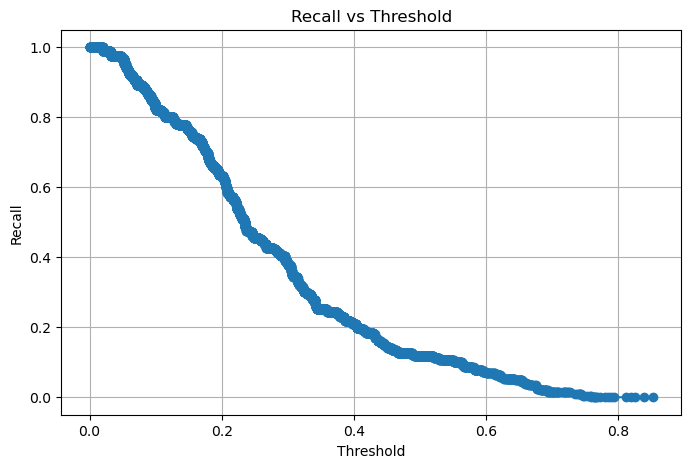

In [84]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# precision, recall, threshold 계산
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

# 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls[:-1], marker='o')
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid(True)
plt.show()


# Remodel w/hyperparameter tuning + Threshold

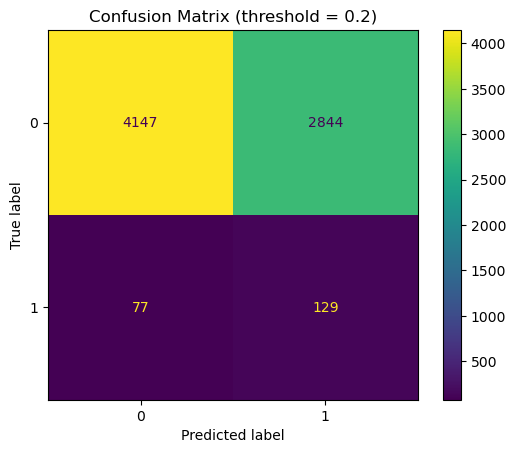

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9818    0.5932    0.7395      6991
           1     0.0434    0.6262    0.0812       206

    accuracy                         0.5941      7197
   macro avg     0.5126    0.6097    0.4104      7197
weighted avg     0.9549    0.5941    0.7207      7197

📈 Evaluation Metrics:
Accuracy:  0.5941
Precision: 0.0434
Recall:    0.6262
F1 Score:  0.0812
ROC AUC:   0.6436
PR AUC:    0.0466

🔍 Feature Importance (Top 15):
              Feature  Importance
18    hungry_weighted    0.057252
20  mean_intensity_1h    0.051865
3        15m_G_Diff_2    0.047859
17           Time_24h    0.042920
34         Sleep_Diff    0.041063
21  mean_intensity_2h    0.040073
22  mean_intensity_3h    0.039443
2        15m_G_Diff_1    0.038815
19         EMA_T_Diff    0.037305
5        15m_G_Diff_4    0.029293
32          TimeInBed    0.028902
4        15m_G_Diff_3    0.028422
33         Efficiency    0.028310
6        

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE
# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/G_1_10_Isnull_diff.csv'
# 
df = pd.read_csv(file_path, encoding="utf-8")

# Convert Time_24h to float hour
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# Feature columns
X_columns = [
    "1D_G_Diff", "3D_G_Diff",
    "15m_G_Diff_1", "15m_G_Diff_2", "15m_G_Diff_3", "15m_G_Diff_4", "15m_G_Diff_5",
    "Glucose", "Slope_Pre_1h", "Slope_Pre_2h", "Slope_Pre_2.5h",
    "Mean_Glucose_Pre_1h", "Mean_Glucose_Pre_2h", "Mean_Glucose_Pre_2.5h",
    "Std_Glucose_Pre_1h", "Std_Glucose_Pre_2h", "Std_Glucose_Pre_2.5h",
    "Time_24h", "hungry_weighted", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h",
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff",
    "TimeInBed_isnull", "Efficiency_isnull", "Sleep_Diff_isnull",
    "hungry_weighted_isnull", "bored_weighted_isnull", "How_stressed_weighted_isnull",
    "How_anxious_weighted_isnull", "How_tired_weighted_isnull"
]

# Remove rows with missing values
df_model = df[X_columns + ["Onset_GE", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

X = df_model[X_columns]
y = df_model["Onset_GE"].astype(int)

# Split train/test
X_train_raw, X_test, y_train_raw, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# SMOTE with dynamic k_neighbors
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Train model
best_model = RandomForestClassifier(
    n_estimators=152,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight='balanced',
    random_state=42
)
best_model.fit(X_train, y_train)

# 7. Predict probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]
threshold = 0.2
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluation
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

# Feature importance
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values("Importance", ascending=False)

print("\n🔍 Feature Importance (Top 15):")
print(importances.head(15))


# SHAP (waterfall)

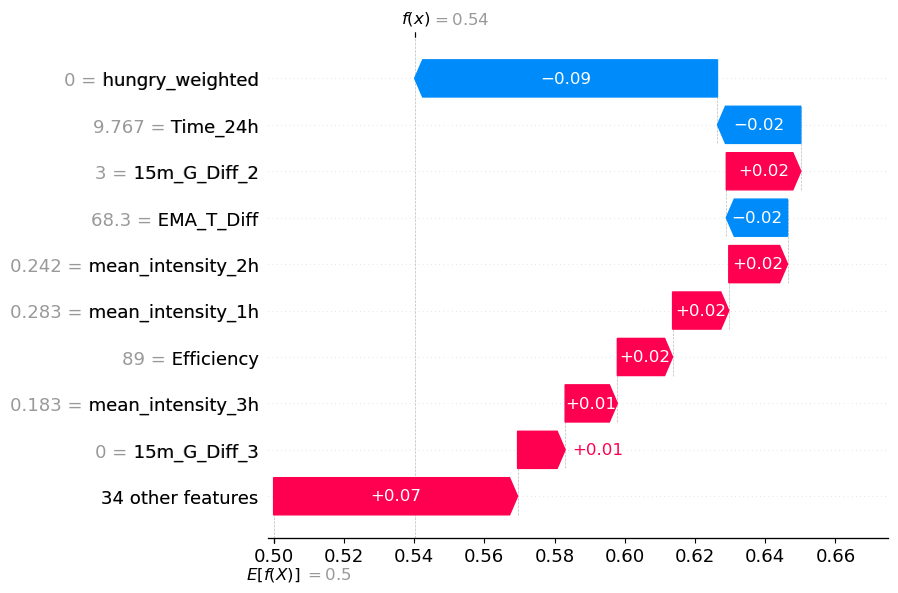

In [112]:
import shap
import numpy as np

# 1️⃣ TreeExplainer 생성
explainer = shap.TreeExplainer(best_model)

# 2️⃣ 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[2]

    # 3️⃣ 해당 샘플
    x_row = X_test.iloc[[idx]]

    # 4️⃣ SHAP 값 계산
    shap_values = explainer.shap_values(x_row)  # returns [class0_array, class1_array]

    # 5️⃣ class 1 기준 waterfall plot
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )


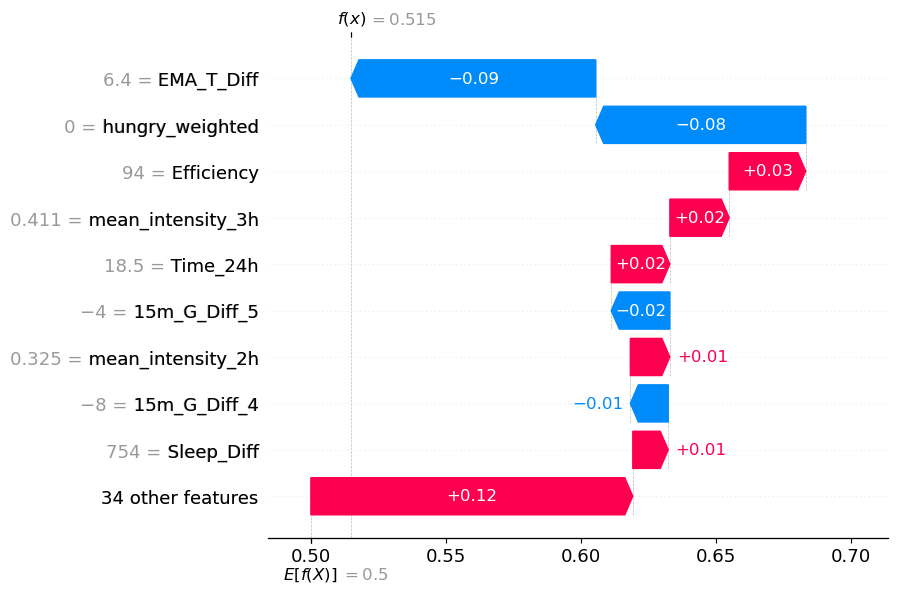

In [114]:
import shap
import numpy as np

# 1️⃣ TreeExplainer 생성
explainer = shap.TreeExplainer(best_model)

# 2️⃣ 확률 0.5 넘는 인덱스 추출
high_prob_indices = np.where(y_proba > 0.5)[0]

if len(high_prob_indices) == 0:
    print("❌ No samples found with predicted probability > 0.5.")
else:
    idx = high_prob_indices[5]

    # 3️⃣ 해당 샘플
    x_row = X_test.iloc[[idx]]

    # 4️⃣ SHAP 값 계산
    shap_values = explainer.shap_values(x_row)  # returns [class0_array, class1_array]

    # 5️⃣ class 1 기준 waterfall plot
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=x_row.values[0],
            feature_names=x_row.columns.tolist()
        )
    )

# ALE Plot

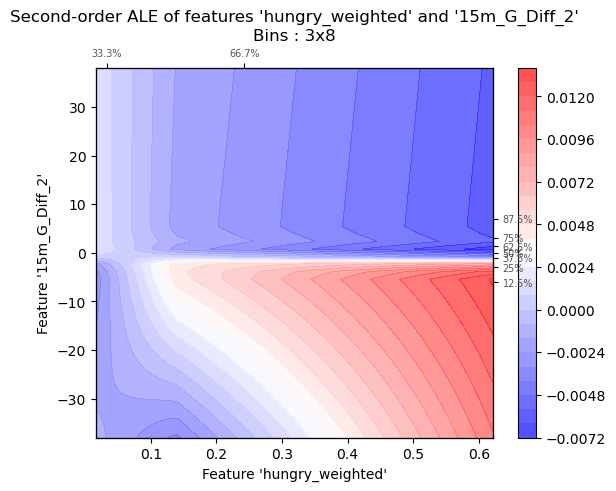

<Axes: title={'center': "Second-order ALE of features 'hungry_weighted' and '15m_G_Diff_2'\nBins : 3x8"}, xlabel="Feature 'hungry_weighted'", ylabel="Feature '15m_G_Diff_2'">

In [155]:
from alepython import ale_plot
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")


# 다만, column 이름을 명시적으로 보장해줌
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# ✅ ALE Plot: 
ale_plot(
    model=best_model,
    train_set=X_train_df,
    features=["hungry_weighted", "15m_G_Diff_2"],
    monte_carlo_rep=1000,  # 
    bins=8  #
)


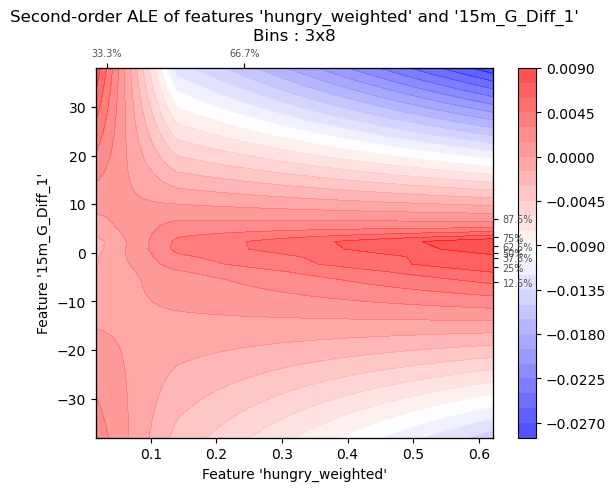

<Axes: title={'center': "Second-order ALE of features 'hungry_weighted' and '15m_G_Diff_1'\nBins : 3x8"}, xlabel="Feature 'hungry_weighted'", ylabel="Feature '15m_G_Diff_1'">

In [217]:
from alepython import ale_plot
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")


# 다만, column 이름을 명시적으로 보장해줌
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# ✅ ALE Plot: 
ale_plot(
    model=best_model,
    train_set=X_train_df,
    features=["hungry_weighted", "15m_G_Diff_1"],
    monte_carlo_rep=1000,  # 
    bins=8 #
)


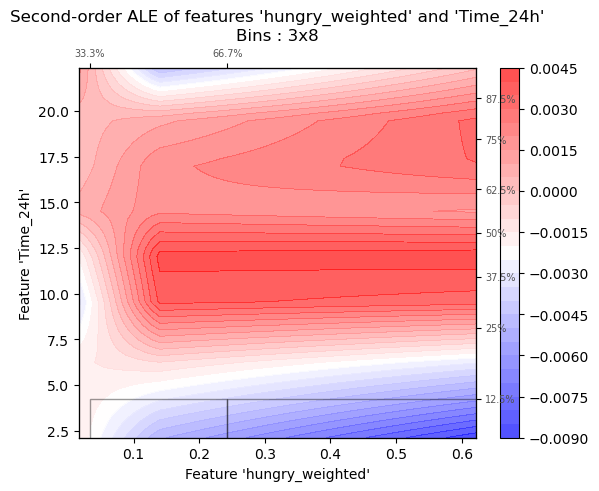

<Axes: title={'center': "Second-order ALE of features 'hungry_weighted' and 'Time_24h'\nBins : 3x8"}, xlabel="Feature 'hungry_weighted'", ylabel="Feature 'Time_24h'">

In [219]:
from alepython import ale_plot
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")


# 다만, column 이름을 명시적으로 보장해줌
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# ✅ ALE Plot: 
ale_plot(
    model=best_model,
    train_set=X_train_df,
    features=["hungry_weighted", "Time_24h"],
    monte_carlo_rep=1000,  # 
    bins=8 #
)

# Validation w/holdout participants

In [222]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from datetime import timedelta

# 1. 홀드아웃 참가자 로드 및 전처리
holdout_ids = [8, 40, 59, 86]
holdout_df = df[df["StudyID"].isin(holdout_ids)].copy()
holdout_df = holdout_df.dropna(subset=X_columns + ["Onset_GE"])

# 2. 예측
X_holdout = holdout_df[X_columns]
y_holdout = holdout_df["Onset_GE"].astype(int)
y_holdout_proba = best_model.predict_proba(X_holdout)[:, 1]
threshold = 0.2
y_holdout_pred = (y_holdout_proba >= threshold).astype(int)

# 3. 결과 merge
holdout_df["Predicted"] = y_holdout_pred
holdout_df["Predicted_Proba"] = y_holdout_proba

# 4. Timestamp 컬럼을 datetime으로 파싱
holdout_df["Timestamp"] = pd.to_datetime(holdout_df["Timestamp"])

# 5. GE onset 발생 60분 전 경고 여부 평가
def detect_early_warning(df, threshold=0.2, lead_minutes=60):
    df = df.sort_values("Timestamp").reset_index(drop=True)
    ge_indices = df.index[df["Onset_GE"] == 1].tolist()
    early_detected = 0

    for ge_idx in ge_indices:
        ge_time = df.loc[ge_idx, "Timestamp"]
        window_start = ge_time - timedelta(minutes=lead_minutes)
        prior_window = df[(df["Timestamp"] >= window_start) & (df["Timestamp"] < ge_time)]

        if (prior_window["Predicted_Proba"] >= threshold).any():
            early_detected += 1

    return early_detected, len(ge_indices)

# 6. 참가자별 평가
results = []
for sid in holdout_df["StudyID"].unique():
    sub_df = holdout_df[holdout_df["StudyID"] == sid]
    detected, total = detect_early_warning(sub_df, threshold=threshold, lead_minutes=60)
    results.append({
        "StudyID": sid,
        "Detected_GE_Onset": detected,
        "Total_GE_Onset": total,
        "Detection_Rate": detected / total if total > 0 else np.nan
    })

# 7. 결과 요약
result_df = pd.DataFrame(results)
print("📊 Early Warning Detection Results (60 min lead window):")
print(result_df)

# 8. 전체 통계
overall_detected = result_df["Detected_GE_Onset"].sum()
overall_total = result_df["Total_GE_Onset"].sum()
overall_rate = overall_detected / overall_total if overall_total > 0 else np.nan

print(f"\n✅ Overall Detection Rate (within 60 min): {overall_detected}/{overall_total} = {overall_rate:.4f}")


📊 Early Warning Detection Results (60 min lead window):
   StudyID  Detected_GE_Onset  Total_GE_Onset  Detection_Rate
0        8                 18              18        1.000000
1       40                 29              30        0.966667
2       59                 12              12        1.000000
3       86                 21              27        0.777778

✅ Overall Detection Rate (within 60 min): 80/87 = 0.9195


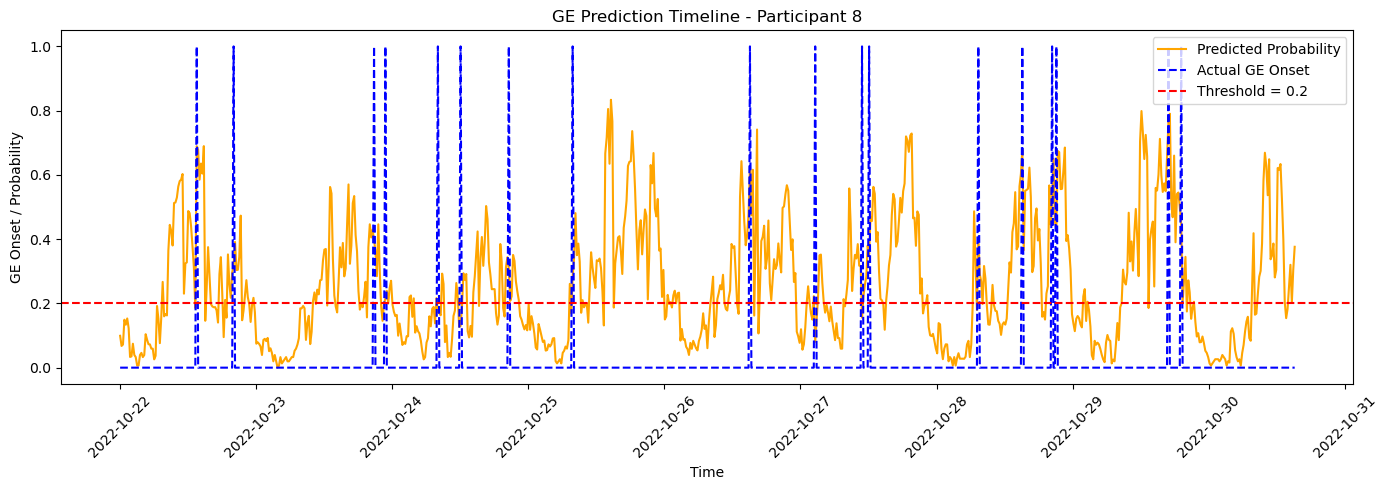

In [224]:
import matplotlib.pyplot as plt

# 참가자별 시계열 예측 확률 시각화
def plot_holdout_predictions(df, study_id, threshold=0.2):
    sub_df = df[df["StudyID"] == study_id].sort_values("Timestamp")

    plt.figure(figsize=(14, 5))
    plt.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    plt.plot(sub_df["Timestamp"], sub_df["Onset_GE"], label="Actual GE Onset", linestyle='--', color="blue")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    plt.title(f"GE Prediction Timeline - Participant {study_id}")
    plt.xlabel("Time")
    plt.ylabel("GE Onset / Probability")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예시: 참가자 8
plot_holdout_predictions(holdout_df, study_id=8)


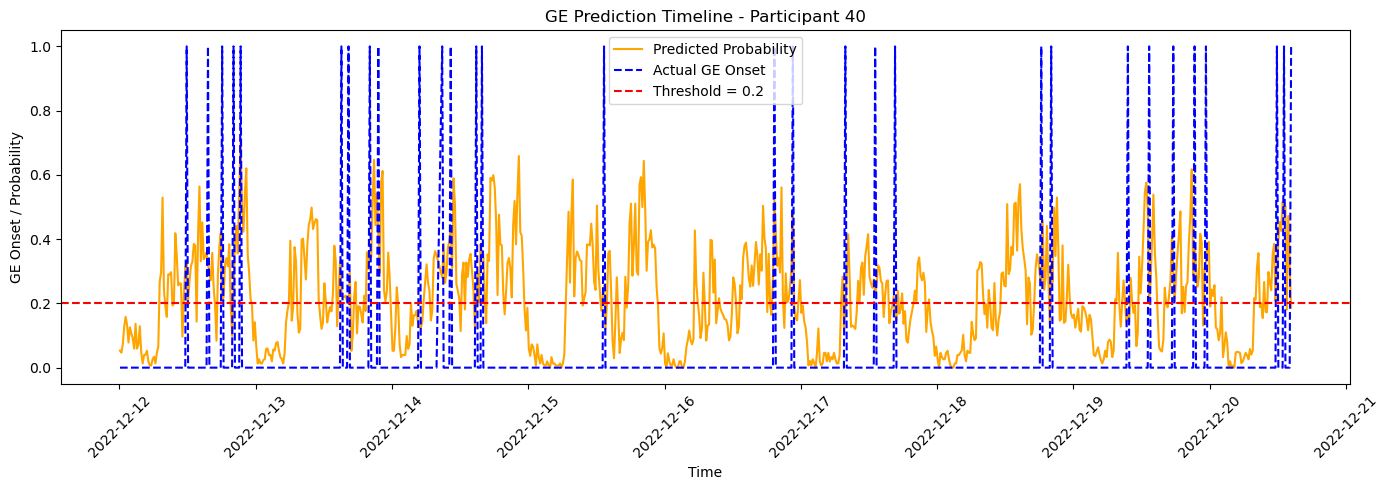

In [230]:
import matplotlib.pyplot as plt

# 참가자별 시계열 예측 확률 시각화
def plot_holdout_predictions(df, study_id, threshold=0.2):
    sub_df = df[df["StudyID"] == study_id].sort_values("Timestamp")

    plt.figure(figsize=(14, 5))
    plt.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    plt.plot(sub_df["Timestamp"], sub_df["Onset_GE"], label="Actual GE Onset", linestyle='--', color="blue")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    plt.title(f"GE Prediction Timeline - Participant {study_id}")
    plt.xlabel("Time")
    plt.ylabel("GE Onset / Probability")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예시: 참가자 8
plot_holdout_predictions(holdout_df, study_id=40)

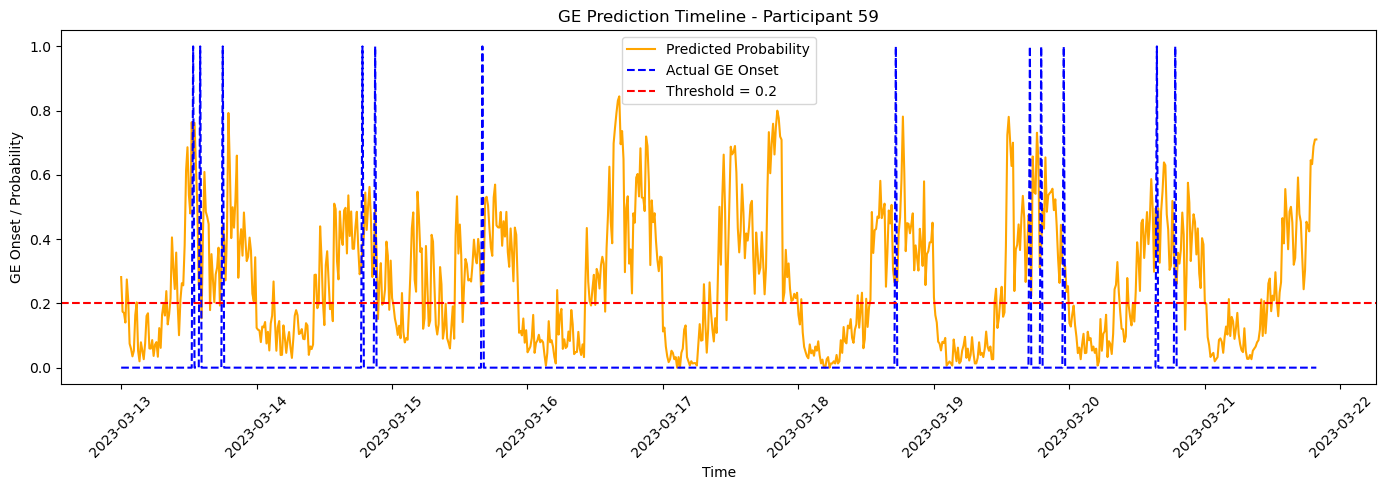

In [232]:
import matplotlib.pyplot as plt

# 참가자별 시계열 예측 확률 시각화
def plot_holdout_predictions(df, study_id, threshold=0.2):
    sub_df = df[df["StudyID"] == study_id].sort_values("Timestamp")

    plt.figure(figsize=(14, 5))
    plt.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    plt.plot(sub_df["Timestamp"], sub_df["Onset_GE"], label="Actual GE Onset", linestyle='--', color="blue")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    plt.title(f"GE Prediction Timeline - Participant {study_id}")
    plt.xlabel("Time")
    plt.ylabel("GE Onset / Probability")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예시: 참가자 8
plot_holdout_predictions(holdout_df, study_id=59)

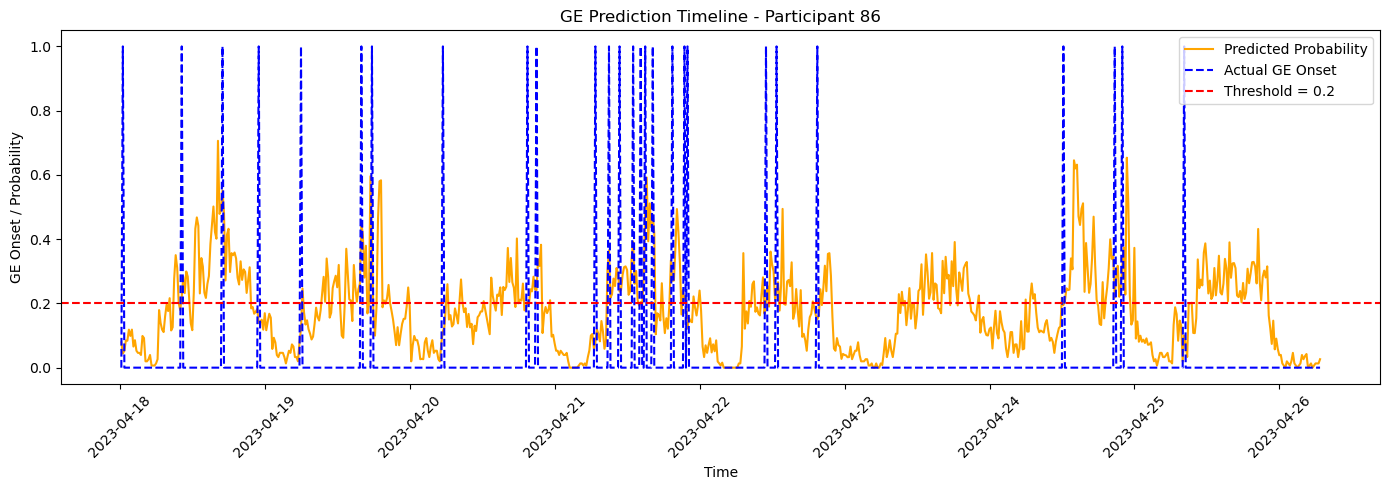

In [234]:
import matplotlib.pyplot as plt

# 참가자별 시계열 예측 확률 시각화
def plot_holdout_predictions(df, study_id, threshold=0.2):
    sub_df = df[df["StudyID"] == study_id].sort_values("Timestamp")

    plt.figure(figsize=(14, 5))
    plt.plot(sub_df["Timestamp"], sub_df["Predicted_Proba"], label="Predicted Probability", color="orange")
    plt.plot(sub_df["Timestamp"], sub_df["Onset_GE"], label="Actual GE Onset", linestyle='--', color="blue")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")

    plt.title(f"GE Prediction Timeline - Participant {study_id}")
    plt.xlabel("Time")
    plt.ylabel("GE Onset / Probability")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 예시: 참가자 8
plot_holdout_predictions(holdout_df, study_id=86)

In [226]:
# FP/FN 라벨 추가
holdout_df["FP"] = ((holdout_df["Predicted"] == 1) & (holdout_df["Onset_GE"] == 0)).astype(int)
holdout_df["FN"] = ((holdout_df["Predicted"] == 0) & (holdout_df["Onset_GE"] == 1)).astype(int)

# 참가자별 FP/FN count
fp_fn_stats = holdout_df.groupby("StudyID")[["FP", "FN"]].sum().reset_index()

print("🔍 False Positive / False Negative per participant:")
print(fp_fn_stats)


🔍 False Positive / False Negative per participant:
   StudyID   FP  FN
0        8  424   4
1       40  401   6
2       59  461   0
3       86  303   9



❗ False Negatives:
       StudyID           Timestamp  Predicted_Proba  Glucose
3866         8 2022-10-24 08:06:00         0.172939       94
3882         8 2022-10-24 12:06:00         0.129923       83
4132         8 2022-10-27 02:36:00         0.080457       96
4165         8 2022-10-27 10:51:00         0.155788      108
22869       40 2022-12-13 16:21:00         0.198152      131

⚠️ False Positives:
      StudyID           Timestamp  Predicted_Proba  Glucose
3672        8 2022-10-22 07:36:00         0.266932       92
3676        8 2022-10-22 08:36:00         0.364698       89
3677        8 2022-10-22 08:51:00         0.444434       92
3678        8 2022-10-22 09:06:00         0.426430      100
3679        8 2022-10-22 09:21:00         0.380275      108


In [242]:
summary = []

for sid in holdout_df["StudyID"].unique():
    df_sub = holdout_df[holdout_df["StudyID"] == sid].copy()
    
    # 
    df_sub["Onset_GE"] = df_sub["Onset_GE"].astype(int)
    df_sub["Predicted"] = df_sub["Predicted"].astype(int)
    
    total = len(df_sub)
    actual_ge = df_sub["Onset_GE"].sum()
    predicted_ge = df_sub["Predicted"].sum()

    tp = ((df_sub["Onset_GE"] == 1) & (df_sub["Predicted"] == 1)).sum()
    fp = ((df_sub["Onset_GE"] == 0) & (df_sub["Predicted"] == 1)).sum()
    fn = ((df_sub["Onset_GE"] == 1) & (df_sub["Predicted"] == 0)).sum()

    precision = precision_score(df_sub["Onset_GE"], df_sub["Predicted"], zero_division=0)
    recall = recall_score(df_sub["Onset_GE"], df_sub["Predicted"], zero_division=0)
    f1 = f1_score(df_sub["Onset_GE"], df_sub["Predicted"], zero_division=0)

    summary.append({
        "StudyID": sid,
        "Total": total,
        "GE Count": actual_ge,
        "Predicted GE": predicted_ge,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

performance_df = pd.DataFrame(summary)
print("📊 Holdout Participant-wise Performance Summary:")
print(performance_df)


📊 Holdout Participant-wise Performance Summary:
   StudyID  Total  GE Count  Predicted GE  TP   FP  FN  Precision  Recall  \
0        8    829        18           438  14  424   4     0.0320  0.7778   
1       40    823        30           425  24  401   6     0.0565  0.8000   
2       59    848        12           473  12  461   0     0.0254  1.0000   
3       86    792        27           321  18  303   9     0.0561  0.6667   

   F1 Score  
0    0.0614  
1    0.1055  
2    0.0495  
3    0.1034  


In [249]:
# 확률 예측
X_holdout = holdout_df[X_columns]
y_holdout_proba = best_model.predict_proba(X_holdout)[:, 1]

# threshold 적용
threshold = 0.2
holdout_df["Predicted"] = (y_holdout_proba >= threshold).astype(int)
holdout_df["Predicted_Proba"] = y_holdout_proba


In [251]:
from datetime import timedelta

# 전제: holdout_df에는 Timestamp, Onset_GE, Predicted, StudyID 컬럼이 존재
window_min = 60
threshold = 0.2  # 설정한 threshold

tp_events = []
fn_events = []
fp_timestamps = []

for sid in holdout_df["StudyID"].unique():
    df_sub = holdout_df[holdout_df["StudyID"] == sid].copy()
    df_sub = df_sub.sort_values("Timestamp").reset_index(drop=True)

    # 모든 GE 이벤트 시점
    ge_times = df_sub[df_sub["Onset_GE"] == 1]["Timestamp"].tolist()

    for ge_time in ge_times:
        window_start = ge_time - timedelta(minutes=window_min)
        prior_window = df_sub[(df_sub["Timestamp"] >= window_start) & (df_sub["Timestamp"] < ge_time)]

        if (prior_window["Predicted"] == 1).any():
            tp_events.append((sid, ge_time))
        else:
            fn_events.append((sid, ge_time))

    # FP 예측 = Predicted==1 인데, 이후 60분 내 GE가 없음
    for idx, row in df_sub[df_sub["Predicted"] == 1].iterrows():
        curr_time = row["Timestamp"]
        future = df_sub[(df_sub["Timestamp"] > curr_time) & 
                        (df_sub["Timestamp"] <= curr_time + timedelta(minutes=window_min))]

        # future 중 GE 없으면 FP로 간주
        if (future["Onset_GE"] == 1).any():
            continue
        else:
            fp_timestamps.append((sid, curr_time))


In [253]:
print("📊 Event-based GE Detection Summary (60 min window):\n")

print(f"🟢 TP (Detected GE events):     {len(tp_events)}")
print(f"🔴 FN (Missed GE events):       {len(fn_events)}")
print(f"⚠️ FP (False alarms):           {len(fp_timestamps)}\n")

# TP rate (event recall)
event_recall = len(tp_events) / (len(tp_events) + len(fn_events)) if (len(tp_events) + len(fn_events)) else 0
print(f"✅ Event-level Recall: {event_recall:.4f}")


📊 Event-based GE Detection Summary (60 min window):

🟢 TP (Detected GE events):     80
🔴 FN (Missed GE events):       7
⚠️ FP (False alarms):           1405

✅ Event-level Recall: 0.9195


# Using top 15 features

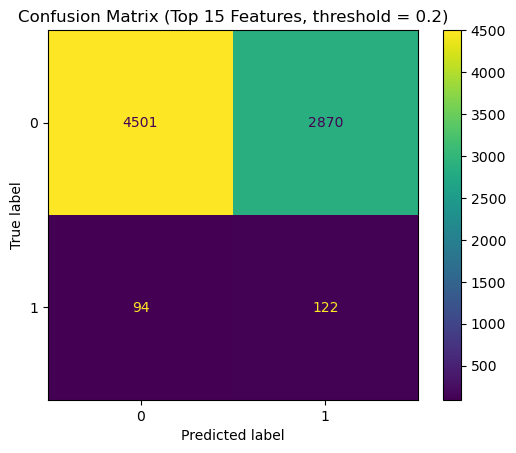

📋 Classification Report:

              precision    recall  f1-score   support

           0     0.9795    0.6106    0.7523      7371
           1     0.0408    0.5648    0.0761       216

    accuracy                         0.6093      7587
   macro avg     0.5102    0.5877    0.4142      7587
weighted avg     0.9528    0.6093    0.7330      7587

📈 Evaluation Metrics:
Accuracy:  0.6093
Precision: 0.0408
Recall:    0.5648
F1 Score:  0.0761
ROC AUC:   0.6300
PR AUC:    0.0486

🔍 Top 15 Features Used:
              Feature  Importance
2        15m_G_Diff_2    0.105760
1   mean_intensity_1h    0.099867
3            Time_24h    0.082828
4          Sleep_Diff    0.072756
0     hungry_weighted    0.071277
5   mean_intensity_2h    0.070205
11       15m_G_Diff_3    0.068719
7        15m_G_Diff_1    0.065225
8          EMA_T_Diff    0.062429
9        15m_G_Diff_4    0.057560
6   mean_intensity_3h    0.053584
13       15m_G_Diff_5    0.048767
10          TimeInBed    0.048631
14          3D_G

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import SMOTE

# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/G_1_10_Isnull_diff.csv'
# 
df = pd.read_csv(file_path, encoding="utf-8")

# Time parsing
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60

# Step 2. Top 15 features만 고정
top15 = [
    "hungry_weighted", "mean_intensity_1h", "15m_G_Diff_2", "Time_24h", "Sleep_Diff",
    "mean_intensity_2h", "mean_intensity_3h", "15m_G_Diff_1", "EMA_T_Diff", "15m_G_Diff_4",
    "TimeInBed", "15m_G_Diff_3", "Efficiency", "15m_G_Diff_5", "3D_G_Diff"
]

# Step 3. 이 기준으로 df_model 생성 (❗ 여기서 top15 사용)
df_model = df[top15 + ["Onset_GE", "StudyID"]].dropna()
df_model = df_model[~df_model["StudyID"].isin([8, 40, 59, 86])]

# Step 4. X, y 정의
X_full = df_model[top15]
y = df_model["Onset_GE"].astype(int)

# Split
X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
    X_full, y, stratify=y, test_size=0.2, random_state=42
)

# Apply SMOTE
minority_class_size = np.bincount(y_train_raw)[1]
k_neighbors = min(5, minority_class_size - 1) if minority_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Fit temporary model to get feature importance
model_temp = RandomForestClassifier(
    n_estimators=152, max_depth=20,
    min_samples_leaf=1, min_samples_split=2,
    class_weight='balanced', random_state=42
)
model_temp.fit(X_train, y_train)

# Select top 15 features
importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model_temp.feature_importances_
}).sort_values("Importance", ascending=False)

top15 = importances["Feature"].iloc[:15].tolist()

# Filter top 15 features
X_train_top15 = X_train[top15]
X_test_top15 = X_test_raw[top15]

# Final model
model = RandomForestClassifier(
    n_estimators=152, max_depth=20,
    min_samples_leaf=1, min_samples_split=2,
    class_weight='balanced', random_state=42
)
model.fit(X_train_top15, y_train)

# Predict
y_proba = model.predict_proba(X_test_top15)[:, 1]
threshold = 0.2
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluate
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh)
plt.title(f"Confusion Matrix (Top 15 Features, threshold = {threshold})")
plt.show()

print("📋 Classification Report:\n")
print(classification_report(y_test, y_pred_thresh, digits=4))
print("📈 Evaluation Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_thresh):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_thresh, zero_division=0):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR AUC:    {average_precision_score(y_test, y_proba):.4f}")

print("\n🔍 Top 15 Features Used:")
print(importances.head(15))
